# Histogram

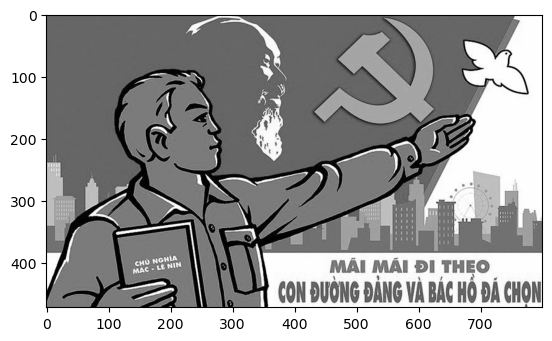

377600
There is 1475 block.
There is 256 threads per block
Creating 377600 
Time elapsed : 39.806400299072266ms


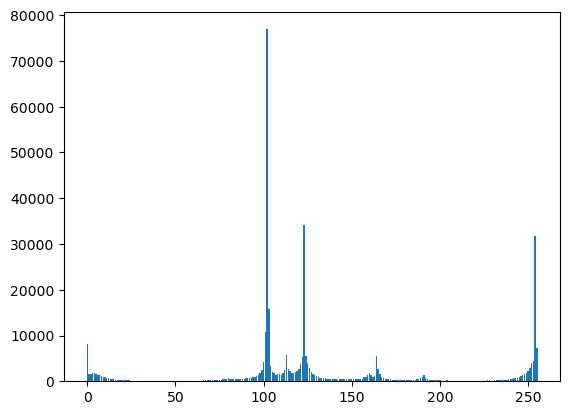

In [ ]:
import numba
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt

image_gray = plt.imread("..\images\image1_gray.jpg")
plt.imshow(image_gray)
plt.show()

if image_gray.ndim == 3:
    HostInp = image_gray[:, :, 0]

(H,W) = HostInp.shape
HostInp = np.ascontiguousarray(HostInp.reshape(H*W))
print(H*W)


@cuda.jit
def histogram(src,histo):
    gtid = cuda.grid(1)
    cuda.atomic.add(histo, src[gtid], 1)






nb_threads = 256
nb_blocks = (HostInp.size + nb_threads - 1)//nb_threads

devInp = cuda.to_device(HostInp)
d_hist = cuda.device_array(256,np.int64)


print(f"There is {nb_blocks} block.")
print(f"There is {nb_threads } threads per block")
print(f"Creating {nb_threads*nb_blocks} ")


stream = cuda.default_stream()
start_event = cuda.event(True)
start_event.record(stream=stream)
histogram[nb_blocks, nb_threads, stream](devInp, d_hist)

stop_event = cuda.event(True)
stop_event.record(stream=stream)
stop_event.synchronize()

time = cuda.event_elapsed_time(start_event,stop_event)
print(f"Time elapsed : {time}ms")

h_hist = d_hist.copy_to_host()

plt.bar([i for i in range(256)],h_hist)
plt.show()



Time elapsed : 46.6769905090332ms


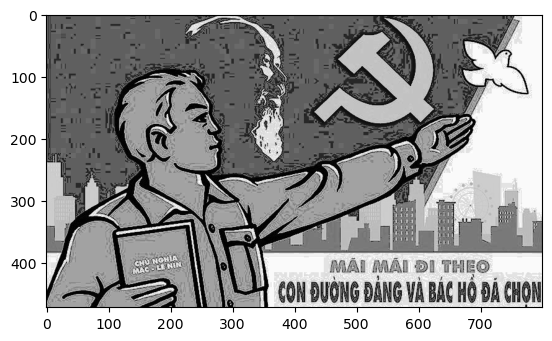

In [73]:
cdf = (np.cumsum(h_hist) / (HostInp.size)) * 255
cdf_device = cuda.to_device(cdf)

@cuda.jit
def equalization(src, cdf, dst):
    x = cuda.grid(1)
    if x < src.size:
        dst[x] = cdf[src[x]]

devOut = cuda.device_array(shape=HostInp.shape,dtype=HostInp.dtype)
stream = cuda.default_stream()
start_event = cuda.event(True)
start_event.record(stream=stream)
equalization[nb_blocks, nb_threads, stream](devInp, cdf_device, devOut)

stop_event = cuda.event(True)
stop_event.record(stream=stream)
stop_event.synchronize()

time = cuda.event_elapsed_time(start_event,stop_event)
print(f"Time elapsed : {time}ms")

hostout = devOut.copy_to_host().reshape((H,W))
plt.imshow(hostout,cmap='gray')
plt.show()



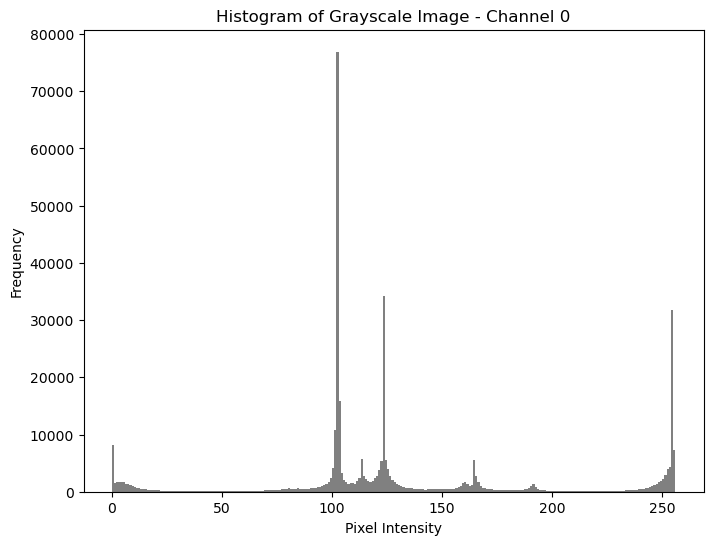

In [16]:
# Load the grayscale image
image_path = "../images/image1_gray.jpg"
image = plt.imread(image_path)

# Check if the image is grayscale; if not, take the first channel (assuming RGB)
if image.ndim == 3:
    image = image[:, :, 0]

# Plot the histogram of pixel intensities for channel 0 (grayscale intensity values)
plt.figure(figsize=(8, 6))
plt.hist(image.ravel(), bins=256, range=(0, 256), color='gray')
plt.title("Histogram of Grayscale Image - Channel 0")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()